In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from time import time

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.scripts.DataLoaders import LeftCamusDataset, get_image_filepaths, ImgForPlot  # HeartLoader
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

from src.scripts.models.U2Net import U2Net 
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    # Check available GPU memory and total GPU memory 
    total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
    print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
    print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 7.224 GB
Total GPU memory: 8.358 GB


In [5]:
img_size = (256, 256)

batch_size = 8
valid_batch_size = 4
epochs = 25
n_print = 500
lr = 0.001

workers = 4

In [6]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Resize(size=img_size),
])

In [7]:
train_path = "data/train/echoLA/training"
test_path = "data/train/echoLA/testing"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), img_format='.jpg')
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), img_format='.jpg')

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), img_format='.png')
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), img_format='.png')

len(img_train_paths), len(msk_test_paths)

(20997, 2235)

In [8]:
train_dataset = LeftCamusDataset(img_train_paths, msk_train_paths, transforms=data_transform)
test_dataset = LeftCamusDataset(img_test_paths, msk_test_paths, transforms=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

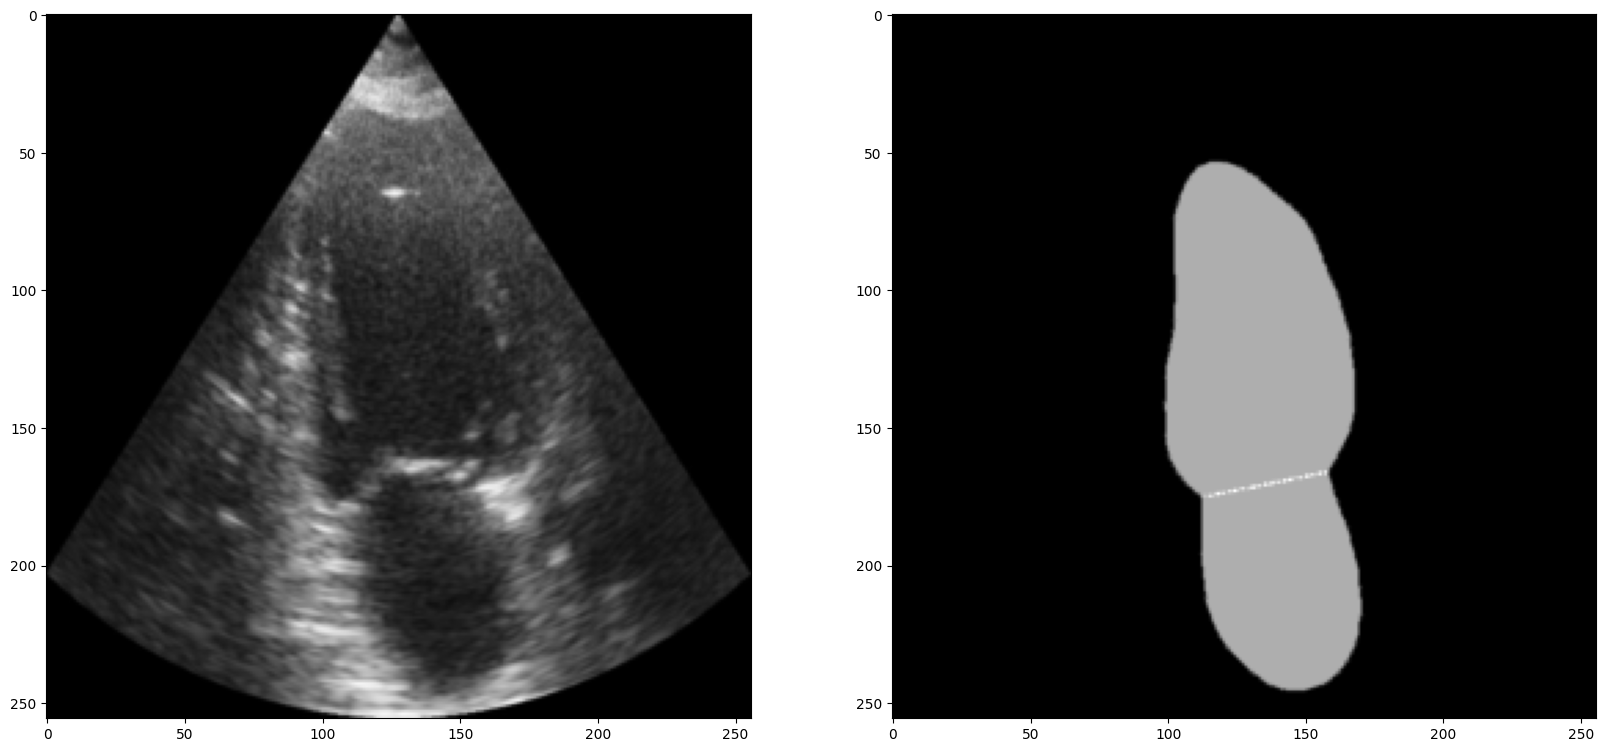

In [9]:
im, m = next(iter(test_dataset))
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m).sum(axis=-1), 'gray');

In [10]:
model_saved_dir = "models/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)
model_name = 'u2net-left'
loss_path = f"{model_saved_dir}/{model_name}_loss.txt"
model_path = f"{model_saved_dir}/{model_name}.pt"
best_model_path = f"{model_saved_dir}/{model_name}_best.pt"

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

model = U2Net(num_classes=2).to(device)
# Continue lerning
# model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

In [12]:
LR_START = 0.001
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0005 # 0.0002

def update_lr(epoch, T):
    # Decrease lr every T epochs
    new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
    print('Learning Rate: %.6f' % new_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [13]:
n_print = 300

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        # print(out.max())
        each_loss = [ DBCE(o, target) for o in out ]   # DBCE
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(test_loader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    # torch.save(model.state_dict(), model_path)
    # with open(loss_path, 'wb') as f:
    #     pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.001000
[ 1/25][ 300/2625] Train: 1.7204 (101s)
[ 1/25][ 600/2625] Train: 1.1321 (101s)
[ 1/25][ 900/2625] Train: 1.0213 (101s)
[ 1/25][1200/2625] Train: 0.9096 (96s)
[ 1/25][1500/2625] Train: 0.8791 (90s)
[ 1/25][1800/2625] Train: 0.8120 (90s)
[ 1/25][2100/2625] Train: 0.8216 (90s)
[ 1/25][2400/2625] Train: 0.7843 (90s)
[ 1/25][2625/2625] Train: 0.8084 (67s)


100%|██████████| 280/280 [00:37<00:00,  7.52it/s]


[ 1/25] Valid: 0.0861 (Best: 0.0861) (37s)
Saved model completely!
Learning Rate: 0.000933
[ 2/25][ 300/2625] Train: 0.7704 (88s)
[ 2/25][ 600/2625] Train: 0.7306 (88s)
[ 2/25][ 900/2625] Train: 0.7237 (88s)
[ 2/25][1200/2625] Train: 0.7033 (88s)
[ 2/25][1500/2625] Train: 0.6866 (89s)
[ 2/25][1800/2625] Train: 0.6663 (88s)
[ 2/25][2100/2625] Train: 0.6745 (96s)
[ 2/25][2400/2625] Train: 0.6498 (100s)
[ 2/25][2625/2625] Train: 0.6276 (75s)


100%|██████████| 280/280 [00:39<00:00,  7.10it/s]


[ 2/25] Valid: 0.0761 (Best: 0.0761) (39s)
Saved model completely!
Learning Rate: 0.000876
[ 3/25][ 300/2625] Train: 0.6043 (99s)
[ 3/25][ 600/2625] Train: 0.5911 (99s)
[ 3/25][ 900/2625] Train: 0.5835 (98s)
[ 3/25][1200/2625] Train: 0.5617 (93s)
[ 3/25][1500/2625] Train: 0.5657 (88s)
[ 3/25][1800/2625] Train: 0.5538 (88s)
[ 3/25][2100/2625] Train: 0.5371 (88s)
[ 3/25][2400/2625] Train: 0.5253 (88s)
[ 3/25][2625/2625] Train: 0.5065 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.93it/s]


[ 3/25] Valid: 0.0668 (Best: 0.0668) (35s)
Saved model completely!
Learning Rate: 0.000826
[ 4/25][ 300/2625] Train: 0.4745 (88s)
[ 4/25][ 600/2625] Train: 0.4722 (88s)
[ 4/25][ 900/2625] Train: 0.4640 (88s)
[ 4/25][1200/2625] Train: 0.4490 (88s)
[ 4/25][1500/2625] Train: 0.4490 (88s)
[ 4/25][1800/2625] Train: 0.4368 (88s)
[ 4/25][2100/2625] Train: 0.4274 (88s)
[ 4/25][2400/2625] Train: 0.4231 (88s)
[ 4/25][2625/2625] Train: 0.4097 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.94it/s]


[ 4/25] Valid: 0.0640 (Best: 0.0640) (35s)
Saved model completely!
Learning Rate: 0.000782
[ 5/25][ 300/2625] Train: 0.3850 (88s)
[ 5/25][ 600/2625] Train: 0.3777 (88s)
[ 5/25][ 900/2625] Train: 0.3785 (88s)
[ 5/25][1200/2625] Train: 0.3732 (88s)
[ 5/25][1500/2625] Train: 0.3661 (88s)
[ 5/25][1800/2625] Train: 0.3565 (88s)
[ 5/25][2100/2625] Train: 0.3577 (95s)
[ 5/25][2400/2625] Train: 0.3501 (99s)
[ 5/25][2625/2625] Train: 0.3439 (73s)


100%|██████████| 280/280 [00:39<00:00,  7.18it/s]


[ 5/25] Valid: 0.0554 (Best: 0.0554) (39s)
Saved model completely!
Learning Rate: 0.000745
[ 6/25][ 300/2625] Train: 0.3242 (98s)
[ 6/25][ 600/2625] Train: 0.3196 (93s)
[ 6/25][ 900/2625] Train: 0.3201 (88s)
[ 6/25][1200/2625] Train: 0.3174 (88s)
[ 6/25][1500/2625] Train: 0.3121 (88s)
[ 6/25][1800/2625] Train: 0.3082 (88s)
[ 6/25][2100/2625] Train: 0.3098 (88s)
[ 6/25][2400/2625] Train: 0.3065 (88s)
[ 6/25][2625/2625] Train: 0.3045 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.96it/s]


[ 6/25] Valid: 0.0553 (Best: 0.0553) (35s)
Saved model completely!
Learning Rate: 0.000712
[ 7/25][ 300/2625] Train: 0.2866 (88s)
[ 7/25][ 600/2625] Train: 0.2809 (88s)
[ 7/25][ 900/2625] Train: 0.2830 (88s)
[ 7/25][1200/2625] Train: 0.2816 (88s)
[ 7/25][1500/2625] Train: 0.2795 (88s)
[ 7/25][1800/2625] Train: 0.2776 (88s)
[ 7/25][2100/2625] Train: 0.2775 (88s)
[ 7/25][2400/2625] Train: 0.2783 (88s)
[ 7/25][2625/2625] Train: 0.2745 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.94it/s]


[ 7/25] Valid: 0.0500 (Best: 0.0500) (35s)
Saved model completely!
Learning Rate: 0.000684
[ 8/25][ 300/2625] Train: 0.2613 (88s)
[ 8/25][ 600/2625] Train: 0.2578 (88s)
[ 8/25][ 900/2625] Train: 0.2590 (88s)
[ 8/25][1200/2625] Train: 0.2611 (88s)
[ 8/25][1500/2625] Train: 0.2562 (88s)
[ 8/25][1800/2625] Train: 0.2562 (88s)
[ 8/25][2100/2625] Train: 0.2520 (88s)
[ 8/25][2400/2625] Train: 0.2563 (88s)
[ 8/25][2625/2625] Train: 0.2544 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.93it/s]


[ 8/25] Valid: 0.0472 (Best: 0.0472) (35s)
Saved model completely!
Learning Rate: 0.000659
[ 9/25][ 300/2625] Train: 0.2427 (88s)
[ 9/25][ 600/2625] Train: 0.2381 (88s)
[ 9/25][ 900/2625] Train: 0.2386 (88s)
[ 9/25][1200/2625] Train: 0.2419 (88s)
[ 9/25][1500/2625] Train: 0.2399 (88s)
[ 9/25][1800/2625] Train: 0.2426 (88s)
[ 9/25][2100/2625] Train: 0.2400 (88s)
[ 9/25][2400/2625] Train: 0.2371 (88s)
[ 9/25][2625/2625] Train: 0.2365 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.93it/s]


[ 9/25] Valid: 0.0449 (Best: 0.0449) (35s)
Saved model completely!
Learning Rate: 0.000638
[10/25][ 300/2625] Train: 0.2286 (88s)
[10/25][ 600/2625] Train: 0.2256 (88s)
[10/25][ 900/2625] Train: 0.2272 (88s)
[10/25][1200/2625] Train: 0.2282 (88s)
[10/25][1500/2625] Train: 0.2286 (88s)
[10/25][1800/2625] Train: 0.2250 (88s)
[10/25][2100/2625] Train: 0.2253 (88s)
[10/25][2400/2625] Train: 0.2268 (88s)
[10/25][2625/2625] Train: 0.2280 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.96it/s]


[10/25] Valid: 0.0437 (Best: 0.0437) (35s)
Saved model completely!
Learning Rate: 0.000620
[11/25][ 300/2625] Train: 0.2184 (88s)
[11/25][ 600/2625] Train: 0.2167 (88s)
[11/25][ 900/2625] Train: 0.2163 (88s)
[11/25][1200/2625] Train: 0.2161 (88s)
[11/25][1500/2625] Train: 0.2159 (88s)
[11/25][1800/2625] Train: 0.2205 (88s)
[11/25][2100/2625] Train: 0.2182 (88s)
[11/25][2400/2625] Train: 0.2159 (88s)
[11/25][2625/2625] Train: 0.2180 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.92it/s]


[11/25] Valid: 0.0428 (Best: 0.0428) (35s)
Saved model completely!
Learning Rate: 0.000604
[12/25][ 300/2625] Train: 0.2081 (88s)
[12/25][ 600/2625] Train: 0.2088 (94s)
[12/25][ 900/2625] Train: 0.2110 (97s)
[12/25][1200/2625] Train: 0.2085 (98s)
[12/25][1500/2625] Train: 0.2096 (96s)
[12/25][1800/2625] Train: 0.2102 (88s)
[12/25][2100/2625] Train: 0.2079 (88s)
[12/25][2400/2625] Train: 0.2085 (88s)
[12/25][2625/2625] Train: 0.2095 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.91it/s]


[12/25] Valid: 0.0418 (Best: 0.0418) (35s)
Saved model completely!
Learning Rate: 0.000590
[13/25][ 300/2625] Train: 0.2032 (88s)
[13/25][ 600/2625] Train: 0.2038 (88s)
[13/25][ 900/2625] Train: 0.2034 (88s)
[13/25][1200/2625] Train: 0.2026 (88s)
[13/25][1500/2625] Train: 0.2010 (88s)
[13/25][1800/2625] Train: 0.2036 (88s)
[13/25][2100/2625] Train: 0.2009 (88s)
[13/25][2400/2625] Train: 0.2025 (88s)
[13/25][2625/2625] Train: 0.2021 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.90it/s]


[13/25] Valid: 0.0416 (Best: 0.0416) (35s)
Saved model completely!
Learning Rate: 0.000578
[14/25][ 300/2625] Train: 0.1977 (88s)
[14/25][ 600/2625] Train: 0.1964 (88s)
[14/25][ 900/2625] Train: 0.1976 (88s)
[14/25][1200/2625] Train: 0.1958 (88s)
[14/25][1500/2625] Train: 0.1989 (88s)
[14/25][1800/2625] Train: 0.1985 (88s)
[14/25][2100/2625] Train: 0.1989 (88s)
[14/25][2400/2625] Train: 0.1978 (88s)
[14/25][2625/2625] Train: 0.2003 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.91it/s]


[14/25] Valid: 0.0410 (Best: 0.0410) (35s)
Saved model completely!
Learning Rate: 0.000568
[15/25][ 300/2625] Train: 0.1934 (88s)
[15/25][ 600/2625] Train: 0.1913 (88s)
[15/25][ 900/2625] Train: 0.1950 (88s)
[15/25][1200/2625] Train: 0.1930 (88s)
[15/25][1500/2625] Train: 0.1920 (88s)
[15/25][1800/2625] Train: 0.1937 (88s)
[15/25][2100/2625] Train: 0.1908 (88s)
[15/25][2400/2625] Train: 0.1938 (88s)
[15/25][2625/2625] Train: 0.1938 (66s)


100%|██████████| 280/280 [00:35<00:00,  7.95it/s]


[15/25] Valid: 0.0400 (Best: 0.0400) (35s)
Saved model completely!
Learning Rate: 0.000559
[16/25][ 300/2625] Train: 0.1915 (88s)
[16/25][ 600/2625] Train: 0.1890 (88s)
[16/25][ 900/2625] Train: 0.1893 (88s)
[16/25][1200/2625] Train: 0.1907 (88s)
[16/25][1500/2625] Train: 0.1890 (88s)
[16/25][1800/2625] Train: 0.1900 (91s)


KeyboardInterrupt: 

In [14]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

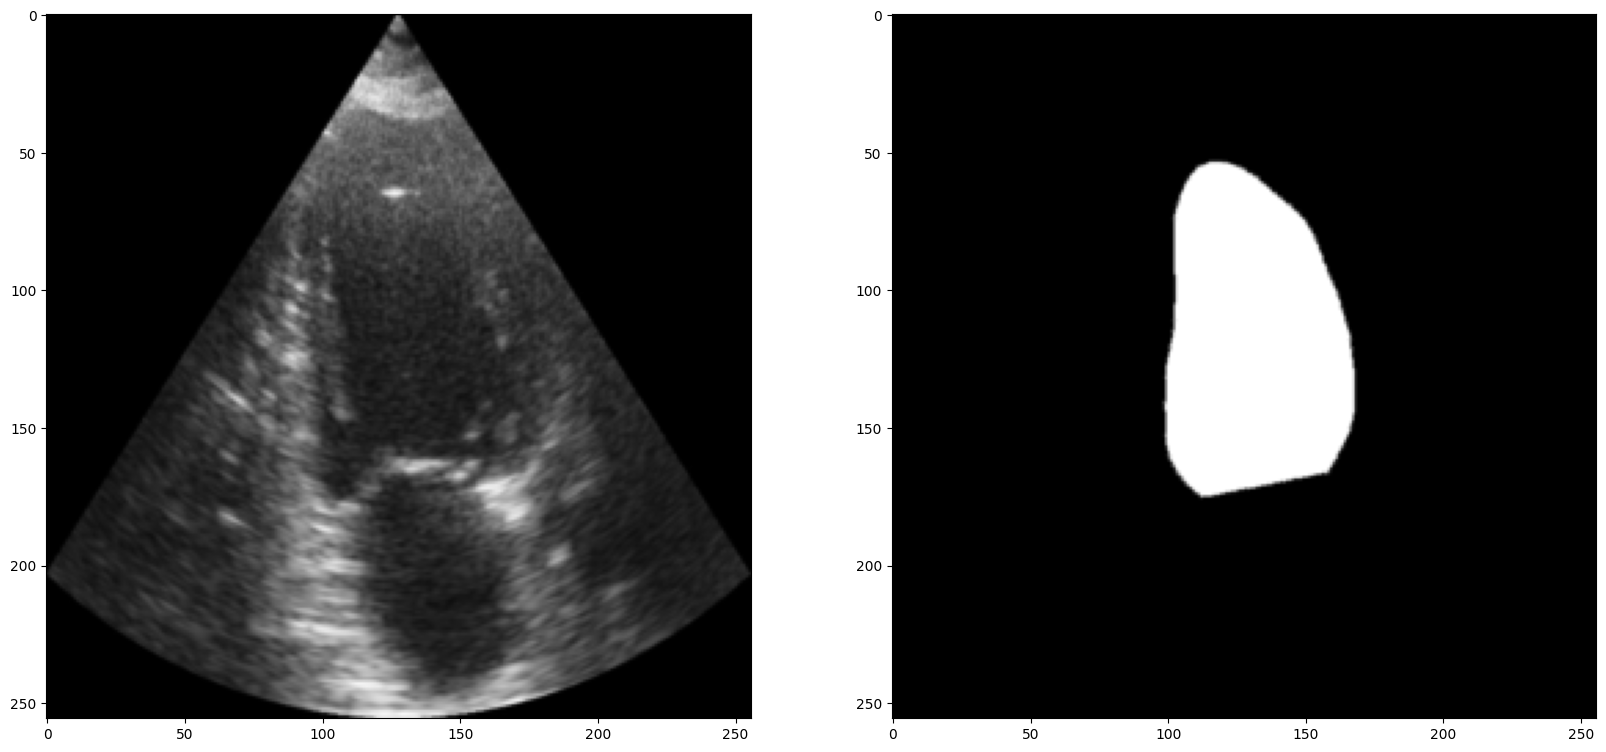

In [15]:
im, m = next(iter(test_dataset))
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m)[:, :, 0], 'gray');

In [16]:
pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

(256, 256, 2)

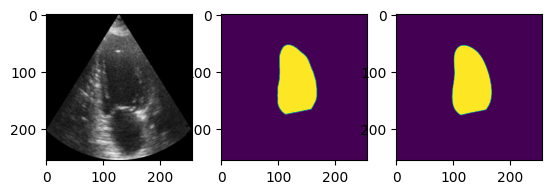

In [17]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
# plt.imshow(im.transpose((1, 2, 0)))
plt.subplot(132)
plt.imshow(ImgForPlot(m)[:, :, 0]);
plt.subplot(133)
plt.imshow(pred[:, :, 0])

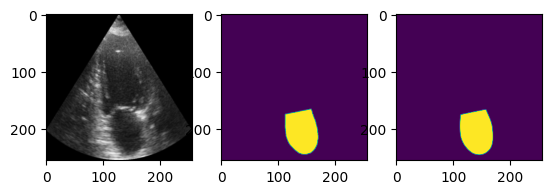

In [18]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
plt.subplot(132)
plt.imshow(ImgForPlot(m)[:, :, 1]);
plt.subplot(133)
plt.imshow(pred[:, :, 1])